In [1]:
!pip install neural_tangents

     |████████████████████████████████| 125 kB 5.5 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
from jax.experimental import optimizers
from jax import jit, grad, vmap
from jax.experimental.ode import odeint
from jax.config import config
config.update("jax_enable_x64", True)

import neural_tangents as nt
from neural_tangents import stax

def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
root_dir = "beneficial_detrimental/"
ensure_dir(root_dir)

## Define Functions to Compute Theoretical Learning Curves

In [4]:
# take in 
softmax = jit(lambda a: jnp.exp(a) / jnp.exp(a).sum())

@jit
def func(kappa, t, params):
    P, lamb, eigs = params
    return lamb + kappa * jnp.sum( eigs / (eigs * P + kappa) ) - kappa

@jit
def solve_kappa(P, lamb, eigs):
    return odeint(func, lamb, jnp.linspace(0.0,250.0, 25), (P,lamb, eigs))[-1]

@jit
def Eg_wrt_test(a, params):
    eigs, phi0, y, P, lamb, train_dist = params
    sm = softmax(a)
    
    O = phi0.T @ jnp.diag(sm) @ phi0

    coeffs = (jnp.diag(train_dist)@phi0).T @ y

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum(eigs**2/(eigs* P + kappa)**2)
    Eg_old = kappa**2/(1-gamma) * jnp.sum(coeffs**2 / (eigs*P + kappa)**2)

    f = jnp.sum(jnp.diag(O) * eigs**2/(eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    G_mid = kappa / (kappa + eigs * P) * coeffs
    Eg = Eg_old * f + jnp.dot(G_mid, (O - f*jnp.eye(O.shape[0])) @ G_mid)

    return Eg
grad_wrt_test = grad(Eg_wrt_test)

def kr_expt_measure_test(Pvals, prob_dist, K, y, lamb, train_dist):
    num_repeat = 35
    errs = np.zeros((len(Pvals), num_repeat))
    key = random.PRNGKey(0)
    for n in range(num_repeat):
        for i,P in enumerate(Pvals):
            _, key = random.split(key)
            inds = np.random.choice(K.shape[0], int(P), p=train_dist, replace = True)
            Ki = K[inds,:]
            Kii = Ki[:,inds]
            yi = y[inds]
            alpha = np.linalg.lstsq(Kii+lamb*np.eye(int(P)), yi, rcond=None)[0]
            yhat = Ki.T @ alpha
            errs[i,n] = np.sum(prob_dist * (yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)


def predictor_uniform(Pvals, X_train, X_test, y, lamb, num_repeat = 50):
    predictor = np.zeros((len(Pvals), num_repeat, len(y)))
    key = random.PRNGKey(0)
    
    K_tr = kernel_fn(X_train, X_train, 'ntk')
    K_te = kernel_fn(X_train, X_test, 'ntk')
    
    for n in range(num_repeat):
        for i,P in enumerate(Pvals):
            _, key = random.split(key)
            inds = np.random.choice(K.shape[0], int(P), replace = True)
            Ki = K_tr[inds,:]
            Ki = Ki[:,inds]
            yi = y[inds]
            alpha = np.linalg.lstsq(Ki+lamb*np.eye(int(P)), yi, rcond=None)[0]
            predictor[i,n] = K_te[inds].T @ alpha
            
    return predictor.mean(axis = 1), predictor.std(axis = 1)



def mnist_binary(N_tr, a, b, shuffle = False):
    from tensorflow import keras
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  
    inds_binary_train = [i for i in range(len(y_train)) if y_train[i]==a or y_train[i]==b]
    inds_binary_test = [i for i in range(len(y_test)) if y_test[i]==a or y_test[i]==b]

    if shuffle:
        inds_binary_train = np.random.choice(inds_binary_train, size = N_tr, replace = False)
    else:
        inds_binary_train = inds_binary_train[:N_tr]

    x_train = x_train[inds_binary_train]
    y_train = y_train[inds_binary_train]
    x_train = x_train.reshape(N_tr, x_train.shape[1]*x_train.shape[2])
    x_train = x_train.T - np.mean(x_train, axis = 1)
    x_train = (x_train / np.linalg.norm(x_train, axis = 0)).T

    
    x_test = x_test[inds_binary_test]
    y_test = y_test[inds_binary_test]
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    x_test = x_test.T - np.mean(x_test, axis = 1)
    x_test = (x_test / np.linalg.norm(x_test, axis = 0)).T

    y_train = 1.0*(y_train == a) - 1.0*(y_train == b)
    y_test = 1.0*(y_test == a) - 1.0*(y_test == b)

    return (x_train, y_train), (x_test, y_test)

## Download and Preprocess Data

In [5]:
def fully_connected(width,depth):
    layers = []
    for l in range(depth):
        layers += [stax.Dense(width), stax.Relu()]
    layers += [stax.Dense(1)]
    return stax.serial(*layers)


width=5000
depth = 2
# define a RELU neural tangent kernel
init_fn, apply_fn, kernel_fn = fully_connected(width, depth)
kernel_fn = jit(kernel_fn, static_argnums=(2,))
apply_fn = jit(apply_fn)

a = 9
b = 8
total_pts = 1000
(X, y_vec), (x_test, y_test) = mnist_binary(total_pts, a, b, shuffle = False)

X = jnp.array(X)
y_vec = jnp.array(y_vec)
lamb = 1e-4

print(y_vec.shape)

11501568/11490434 [==============================] - 0s 0us/step


(1000,)


# Perform Eigendecomposition to get Eigenvalues and Eigenvectors of the Kernel

### Run This code before optimizing: The kernel is scaled accurately here

In [6]:
K = kernel_fn(X, None, 'ntk')
eig0, phi0 = jnp.linalg.eigh(1/K.shape[0] * K)
phi0 = jnp.sqrt(K.shape[0]) * phi0
eig0 = jnp.abs(eig0)
psi0 =  phi0 @ jnp.diag(jnp.sqrt(eig0))
coeff_phi = 1/K.shape[0] * phi0.T @ y_vec


# Optimize Test Measure for Fixed Training Measure

### Under gradient descent find beneficial examples
### Check these examples are classified correctly
### Add noise to them and see which ones get wrongly classified
### Replace these examples in the test set
### Again run gradient descent to see if they become adverserial examples

In [ ]:
K = kernel_fn(X, None, 'ntk')
eig0, phi0 = jnp.linalg.eigh(1/K.shape[0] * K)
phi0 = jnp.sqrt(K.shape[0]) * phi0
eig0 = jnp.abs(eig0)

epoch_list = [90]
P_list = np.array([30.])
train_dist = jnp.ones(len(K))/len(K)

epoch_ben_dist = []
epoch_adv_dist = []

for epoch in epoch_list:
    opt_init, opt_update, get_params = optimizers.adam(0.05)
    all_final_ben = []
    key = random.PRNGKey(1)
    for i, P in enumerate(P_list):
        opt_state = opt_init(jnp.zeros(K.shape[0]))
        params = (eig0, phi0, y_vec, P, lamb, train_dist)
        losses = []
        for t in range(epoch):
            losst = Eg_wrt_test(get_params(opt_state), params)
            if t % (epoch//3)  == 0:
                print("loss %0.5f | participation ratio = %0.5f" % (losst,  1.0/(softmax(get_params(opt_state))**2 ).sum()))
            g = grad_wrt_test(get_params(opt_state), params)
            opt_state= opt_update(t, g, opt_state)
            losses += [losst]
        all_final_ben += [get_params(opt_state)]

    opt_init, opt_update, get_params = optimizers.adam(0.05)
    all_final_adv = []
    key = random.PRNGKey(1)
    for i, P in enumerate(P_list):
        opt_state = opt_init(jnp.zeros(K.shape[0]))
        params = (eig0, phi0, y_vec, P, lamb, train_dist)
        losses = []
        for t in range(epoch):
            losst = Eg_wrt_test(get_params(opt_state), params)
            if t % (epoch//3)  == 0:
                print("loss %0.5f | participation ratio = %0.5f" % (losst,  1.0/(softmax(get_params(opt_state))**2 ).sum()))
            g = grad_wrt_test(get_params(opt_state), params)
            opt_state= opt_update(t, -g, opt_state)
            losses += [losst]
        all_final_adv += [get_params(opt_state)]
        
        
    epoch_ben_dist += [all_final_ben]
    epoch_adv_dist += [all_final_adv]
epoch_ben_dist = np.array(epoch_ben_dist)
epoch_adv_dist = np.array(epoch_adv_dist)

In [ ]:
e_idx = 0
P_idx = 0

idx_ben = jnp.argsort(softmax(epoch_ben_dist[e_idx][P_idx]))[::-1]
idx_adv = jnp.argsort(softmax(epoch_adv_dist[e_idx][P_idx]))[::-1]

epoch_ben_sort = []
epoch_adv_sort = []
epoch_uni_sort = []
for epoch_ben, epoch_adv in zip(epoch_ben_dist, epoch_adv_dist):
    epoch_ben_sort += [softmax(epoch_ben[P_idx][idx_ben])]
    epoch_adv_sort += [softmax(epoch_adv[P_idx][idx_ben])]

epoch_ben_sort = np.array(epoch_ben_sort)
epoch_adv_sort = np.array(epoch_adv_sort)


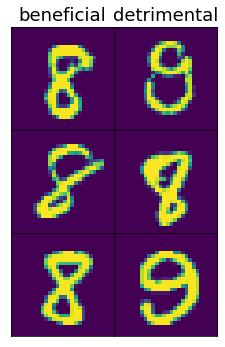

In [ ]:
num_samp = 3
fig, axs = plt.subplots(num_samp,2,figsize=(3.7,5.7))
axs = axs.T
X_ben = X[idx_ben[:num_samp]].reshape(num_samp,28,28)
X_adv = X[idx_adv[:num_samp]].reshape(num_samp,28,28)

for i, x_ben, x_adv in zip(range(num_samp),X_ben,X_adv):
    axs[0,i].imshow(x_ben)
    axs[1,i].imshow(x_adv)
    axs[1,i].set_xticks([])
    axs[0,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_yticks([])
axs[0,0].set_title('beneficial', fontsize=18)
axs[1,0].set_title('detrimental', fontsize=18)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(root_dir+'ben_adv_samples.png', dpi=200)

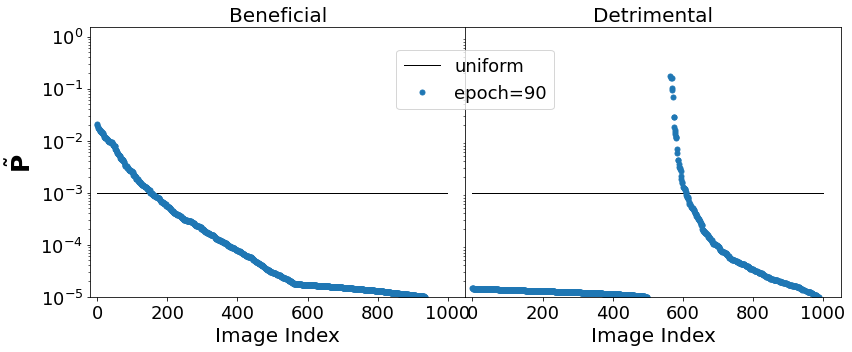

In [ ]:
epoch_idx = [0]
fig, axs = plt.subplots(1,2,figsize=(12,5))
for i, ben_sorted,adv_sorted in zip(epoch_idx, epoch_ben_sort[epoch_idx], epoch_adv_sort[epoch_idx]):
    uni_sorted = softmax(jnp.zeros(phi0.shape[0]))
    if i == 0:
        axs[0].plot(uni_sorted, '-',color = 'black', label = 'uniform', linewidth=1)
        axs[1].plot(uni_sorted, '-',color = 'black', label = 'uniform', linewidth=1)
    axs[0].semilogy(ben_sorted*(ben_sorted>1e-5), 'o', label = 'epoch=%d'%epoch_list[i], color='C%d'%i, markersize=5)
    axs[1].semilogy(adv_sorted*(adv_sorted>1e-5), 'o', label = 'epoch=%d'%epoch_list[i], color='C%d'%i, markersize=5, linewidth=2)
    
axs[0].set_title(r'Beneficial',fontsize = 20)
axs[1].set_title(r'Detrimental',fontsize = 20)
axs[0].set_xlabel(r'Image Index',fontsize = 20)
axs[1].set_xlabel(r'Image Index',fontsize = 20)
axs[0].set_ylabel(r'$\tilde\mathbf{P}$',fontsize=25)
axs[0].tick_params(axis='x', labelsize= 18)
axs[1].tick_params(axis='x', labelsize= 18)
axs[0].tick_params(axis='y', labelsize= 18)
axs[1].legend(fontsize = 18, loc='best', bbox_to_anchor=(-0.24, 0.45, 0.5, 0.5))
plt.tight_layout()
axs[1].set_yticks([])    
axs[0].set_xlim([-20, 1050])
axs[1].set_xlim([-20, 1050])
axs[0].set_ylim([1e-5, 1.5])
axs[1].set_ylim([1e-5, 1.5])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(root_dir + 'adv_vs_beneficial_measure.pdf')
plt.show()

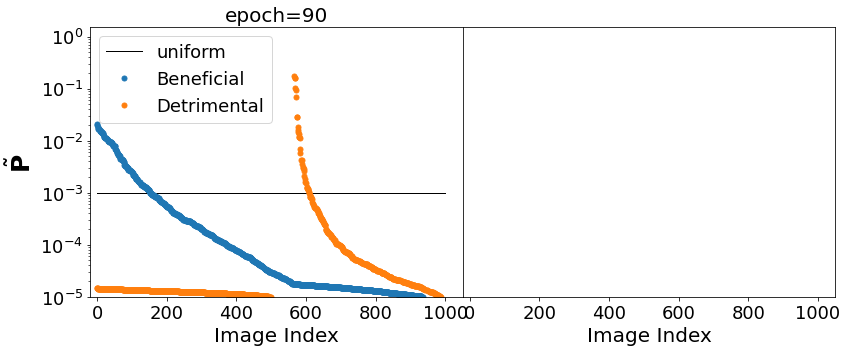

In [ ]:
epoch_idx = [0]
fig, axs = plt.subplots(1,2,figsize=(12,5))
for i, idx, ben_sorted,adv_sorted in zip(range(len(epoch_idx)), epoch_idx, epoch_ben_sort[epoch_idx], epoch_adv_sort[epoch_idx]):

    uni_sorted = softmax(jnp.zeros(phi0.shape[0]))

    axs[i].plot(uni_sorted, '-',color = 'black', label = 'uniform', linewidth=1)
        
    axs[i].semilogy(ben_sorted*(ben_sorted>1e-5), 'o', label = 'Beneficial', color='C0', markersize=5)
    axs[i].semilogy(adv_sorted*(adv_sorted>1e-5), 'o', label = 'Detrimental', color='C1', markersize=5, linewidth=2)
    axs[i].set_title(r'epoch=%d'%epoch_list[idx],fontsize = 20)
    
axs[0].set_xlabel(r'Image Index',fontsize = 20)
axs[1].set_xlabel(r'Image Index',fontsize = 20)
axs[0].set_ylabel(r'$\tilde\mathbf{P}$',fontsize=25)
axs[0].tick_params(axis='x', labelsize= 18)
axs[1].tick_params(axis='x', labelsize= 18)
axs[0].tick_params(axis='y', labelsize= 18)
axs[0].legend(fontsize = 18, loc='best')
plt.tight_layout()
axs[1].set_yticks([])    
axs[0].set_xlim([-20, 1050])
axs[1].set_xlim([-20, 1050])
axs[0].set_ylim([1e-5, 1.5])
axs[1].set_ylim([1e-5, 1.5])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(root_dir + 'adv_vs_beneficial_measure.pdf')
plt.show()

In [ ]:
uniform = softmax(jnp.zeros(K.shape[0]))
Pvals_th = jnp.linspace(1,100,100)
Pvals_expt = np.linspace(5, 100, 10)

print('Kernel Regression for Uniform')
err_uni, std_uni = kr_expt_measure_test(Pvals_expt, uniform, K, y_vec, lamb, train_dist)
err_ker_uni = err_uni
std_ker_uni = std_uni
theory_uni = jnp.array([Eg_wrt_test(jnp.zeros(y_vec.shape[0]), (eig0, phi0, y_vec, P, lamb, train_dist)) for P in Pvals_th])

err_ker_ben = []
std_ker_ben = []
theory_ben =[]

err_ker_adv = []
std_ker_adv = []
theory_adv =[]

for e_idx in range(len(epoch_list)):
    theory_ben_P = []
    theory_adv_P = []
    err_ker_ben_P = []
    std_ker_ben_P = []
    err_ker_adv_P = []
    std_ker_adv_P = []
    for P_idx in range(epoch_ben_dist.shape[1]):
        print(epoch_list[e_idx])
        ben_dist = epoch_ben_dist[e_idx][P_idx]
        adv_dist = epoch_adv_dist[e_idx][P_idx]

        theory_ben_P += [jnp.array([Eg_wrt_test(ben_dist, (eig0, phi0, y_vec, P, lamb, train_dist)) for P in Pvals_th])]
        theory_adv_P += [jnp.array([Eg_wrt_test(adv_dist, (eig0, phi0, y_vec, P, lamb, train_dist)) for P in Pvals_th])]

        print('Kernel Regression for Beneficial')
        err_ben, std_ben = kr_expt_measure_test(Pvals_expt, softmax(ben_dist), K, y_vec, lamb, train_dist)
        err_ker_ben_P += [err_ben]
        std_ker_ben_P += [std_ben]
        print('Kernel Regression for Detrimental')
        err_adv, std_adv = kr_expt_measure_test(Pvals_expt, softmax(adv_dist), K, y_vec, lamb, train_dist)
        err_ker_adv_P += [err_adv]
        std_ker_adv_P += [std_adv]

    theory_ben += [theory_ben_P]
    theory_adv += [theory_adv_P]
    err_ker_ben += [err_ker_ben_P]
    std_ker_ben += [std_ker_ben_P]
    err_ker_adv += [err_ker_adv_P]
    std_ker_adv += [std_ker_adv_P]
    

Kernel Regression for Uniform
90
Kernel Regression for Beneficial
Kernel Regression for Detrimental


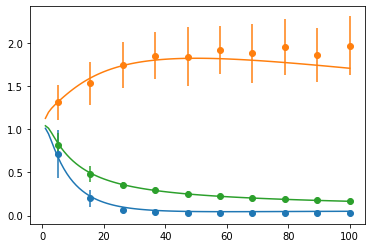

In [ ]:
plt.errorbar(Pvals_expt, err_ker_ben[e_idx][P_idx], std_ker_ben[e_idx][P_idx] , fmt='o', color = 'C%d'%0, label='epoch: %d'%epoch_list[e_idx])
plt.plot(Pvals_th, theory_ben[0][0])

plt.errorbar(Pvals_expt, err_ker_adv[e_idx][P_idx], std_ker_adv[e_idx][P_idx] , fmt='o', color = 'C%d'%1, label='epoch: %d'%epoch_list[e_idx])
plt.plot(Pvals_th, theory_adv[0][0])

plt.errorbar(Pvals_expt, err_ker_uni, std_ker_uni , fmt='o', color = 'C%d'%2, label='epoch: %d'%epoch_list[e_idx])
plt.plot(Pvals_th, theory_uni)


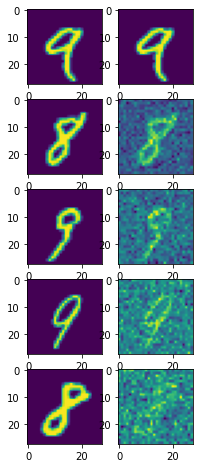

In [ ]:
max_noise = abs(np.min(X))
noise_list = np.linspace(0,max_noise,5)*4

noise_values = np.array([noise_std*np.random.standard_normal(X.shape) for noise_std in noise_list])

fig, axs = plt.subplots(len(noise_values),2, figsize=(3,8))
for i, noise in enumerate(noise_values):
    x = X[i].reshape(28,28)
    noise = noise[i].reshape(28,28)
    axs[i,0].imshow(x)
    axs[i,1].imshow(x+noise)

In [ ]:
y_hat_noise = []

for noise in noise_values:
    y_hat, y_hat_std = predictor_uniform(P_list, X, X + noise, y_vec, lamb, num_repeat = 1000)
    y_hat_noise += [y_hat]
    
y_hat_noise = np.array(y_hat_noise)
y_hat_noise_onehot = 2*np.heaviside(y_hat_noise,0)-1


In [ ]:
## For each data budget P find which images are classified correctly for original images
## For larger data budgets classification accuracy improves

noise_idx = 0
corr_inds = np.array([(y == y_vec) for y in y_hat_noise_onehot[noise_idx]])
print(corr_inds.mean(1))

## Now when there is noise, find which samples misclassifies when tested on

noise_idx = -1
corr_inds_noise = np.array([(y == y_vec) for y in y_hat_noise_onehot[noise_idx]])
print(corr_inds_noise.mean())

[0.965]
0.899


In [ ]:
P_idx = 0
inds_correct = corr_inds[P_idx] == True
## Convert correctly classified indices when noise added to false
corr_inds_noise[P_idx][np.logical_not(inds_correct)] = False

print(corr_inds[P_idx].sum()-corr_inds_noise[P_idx].sum())

## After noise addition, these are the misclassified images
miss_classified_inds = corr_inds[P_idx]^corr_inds_noise[P_idx]
#miss_classified_inds = corr_inds_noise[P_idx]

num_miss_class = miss_classified_inds.sum()

70


In [ ]:
np.square(y_vec[miss_classified_inds] - y_hat_noise_onehot[-1,0][miss_classified_inds]).mean()

4.0

## Now generate a new dataset with last miss_classified_inds.sum() digits being misclassified images

In [ ]:
X_new = np.append(X, X[miss_classified_inds] + noise_values[noise_idx][miss_classified_inds], axis = 0)
y_new = np.append(y_vec, y_vec[miss_classified_inds], axis = 0)

In [ ]:
K_new = kernel_fn(X_new, None, 'ntk')

uniform = softmax(jnp.zeros(K_new.shape[0]))
eig0, phi0 = jnp.linalg.eigh(jnp.diag(jnp.sqrt(uniform)) @ K_new @ jnp.diag(jnp.sqrt(uniform)))
phi0 = jnp.linalg.pinv(jnp.diag(jnp.sqrt(uniform))) @ phi0
eig0 = jnp.abs(eig0)

tr_dist = np.append(softmax(jnp.zeros(X.shape[0])), [0 for _ in range(num_miss_class)])
# # Eigendecomposition of training kernel
# eig0, phi0 = jnp.linalg.eigh(jnp.diag(jnp.sqrt(tr_dist)) @ K_new @ jnp.diag(jnp.sqrt(tr_dist)))
# phi0 = jnp.linalg.pinv(jnp.diag(jnp.sqrt(tr_dist))) @ phi0

epoch_ben_dist = []
epoch_adv_dist = []
epoch_list = [100]
for epoch in epoch_list:
    opt_init, opt_update, get_params = optimizers.adam(0.05)
    all_final_ben = []
    key = random.PRNGKey(1)
    for i, P in enumerate(P_list):
        opt_state = opt_init(jnp.zeros(K_new.shape[0]))
        params = (eig0, phi0, y_new, P, lamb, tr_dist)
        losses = []
        for t in range(epoch):
            losst = Eg_wrt_test(get_params(opt_state), params)
            if t % (epoch//3)  == 0:
                print("loss %0.5f | participation ratio = %0.5f" % (losst,  1.0/(softmax(get_params(opt_state))**2).sum()))
            g = grad_wrt_test(get_params(opt_state), params)
            opt_state= opt_update(t, g, opt_state)
            losses += [losst]
        all_final_ben += [get_params(opt_state)]

    opt_init, opt_update, get_params = optimizers.adam(0.05)
    all_final_adv = []
    key = random.PRNGKey(1)
    for i, P in enumerate(P_list):
        opt_state = opt_init(jnp.zeros(K_new.shape[0]))
        params = (eig0, phi0, y_new, P, lamb, tr_dist)
        losses = []
        for t in range(epoch):
            losst = Eg_wrt_test(get_params(opt_state), params)
            if t % (epoch//3)  == 0:
                print("loss %0.5f | participation ratio = %0.5f" % (losst,  1.0/(softmax(get_params(opt_state))**2 ).sum()))
            g = grad_wrt_test(get_params(opt_state), params)
            opt_state= opt_update(t, -g, opt_state)
            losses += [losst]
        all_final_adv += [get_params(opt_state)]
        
        
    epoch_ben_dist += [all_final_ben]
    epoch_adv_dist += [all_final_adv]
epoch_ben_dist = np.array(epoch_ben_dist)
epoch_adv_dist = np.array(epoch_adv_dist)

loss 0.48724 | participation ratio = 1070.00000
loss 0.27949 | participation ratio = 518.45084
loss 0.19784 | participation ratio = 199.36581
loss 0.14506 | participation ratio = 48.99758
loss 0.48724 | participation ratio = 1070.00000
loss 0.91489 | participation ratio = 288.54058
loss 1.43036 | participation ratio = 51.16725
loss 1.94154 | participation ratio = 6.63704


In [ ]:
P_idx = 0

idx_ben = np.argsort(np.array(softmax(epoch_ben_dist[0][P_idx])))[::-1]
idx_adv = np.argsort(np.array(softmax(epoch_adv_dist[0][P_idx])))[::-1]

epoch_ben_sort = []
epoch_adv_sort = []
epoch_uni_sort = []
for epoch_ben, epoch_adv in zip(epoch_ben_dist, epoch_adv_dist):
    epoch_ben_sort += [softmax(epoch_ben[P_idx][idx_ben])]
    epoch_adv_sort += [softmax(epoch_adv[P_idx][idx_ben])]

epoch_ben_sort = np.array(epoch_ben_sort)
epoch_adv_sort = np.array(epoch_adv_sort)

In [ ]:
(idx_adv>1000).sum()

69

In [ ]:
epoch_ben_sort.shape

(1, 1070)

array([  54,   11,  224,  437,  695,   53,  289,  466,  416,   59, 1025,
        449,  860, 1014,  200, 1048,   83,  832,  809,  651,  965, 1008,
        588, 1067,  542, 1030,  455,  796,  579,   49, 1028,  737,  507,
         89,  905,   52,  446,  114,  234,   23,  816, 1005])

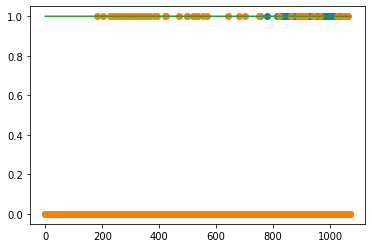

In [ ]:
plt.plot(idx_ben>1000,'o')
plt.plot(idx_adv>1000,'o')
plt.plot(np.ones_like(idx_adv))
idx_ben[::-1][:42]

In [ ]:
softmax(epoch_ben_dist[0][P_idx])[idx_ben[idx_ben>1000]].sum()

DeviceArray(0.0004201, dtype=float64)

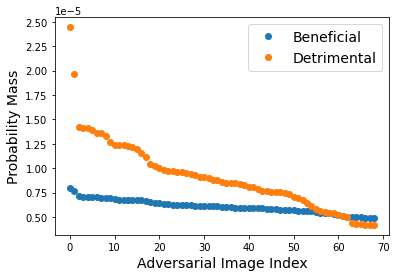

In [ ]:
plt.plot(softmax(epoch_ben_dist[0][P_idx])[idx_ben[idx_ben>1000]], 'o', label='Beneficial')
plt.plot(softmax(epoch_adv_dist[0][P_idx])[idx_adv[idx_adv>1000]], 'o', label='Detrimental')
plt.legend(fontsize=14)
plt.xlabel('Adversarial Image Index', fontsize=14)
plt.ylabel('Probability Mass', fontsize=14)
plt.savefig('adversarial_prob_dist.pdf')

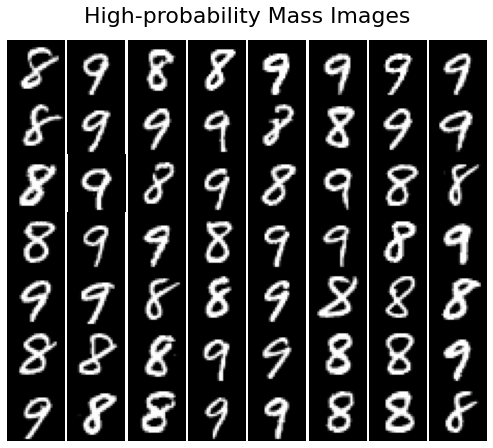

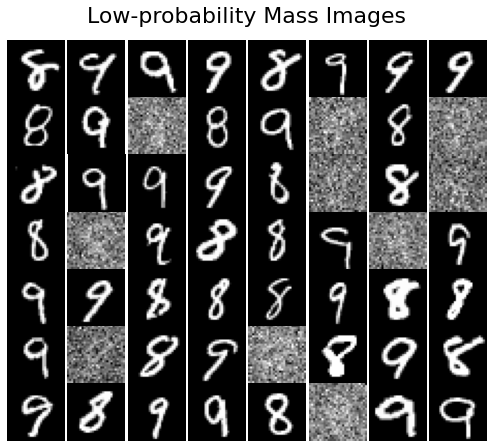

In [ ]:
num_samp =num_miss_class+3
X_high = X_new[idx_ben[:num_samp]].reshape(num_samp,28,28)
X_low = X_new[idx_ben[::-1][:num_samp]].reshape(num_samp,28,28)

fig, axs = plt.subplots(7,8, figsize=(7,6.3)) 
for j, a in enumerate(axs.flatten()):
    a.imshow(X_high[j].reshape((28,28)), cmap = 'gray')
    a.axis('off')
fig.suptitle('High-probability Mass Images', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(wspace =0,hspace=0)
plt.savefig('fixed_test_best_digits.pdf')

plt.show()

fig, axs = plt.subplots(7,8, figsize=(7,6.3)) 
for j, a in enumerate(axs.flatten()):
    a.imshow(X_low[j].reshape((28,28)), cmap = 'gray')
    a.axis('off')
fig.suptitle('Low-probability Mass Images', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(wspace =0,hspace=0)
plt.savefig('fixed_test_worst_digits.pdf')
plt.show()


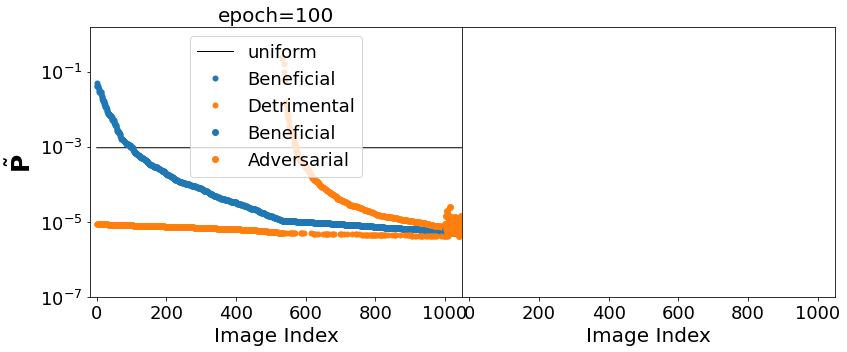

In [ ]:
epoch_idx = [0]
fig, axs = plt.subplots(1,2,figsize=(12,5))
for i, idx, ben_sorted,adv_sorted in zip(range(len(epoch_idx)), epoch_idx, epoch_ben_sort[epoch_idx], epoch_adv_sort[epoch_idx]):

    uni_sorted = softmax(jnp.zeros(phi0.shape[0]))

    axs[i].plot(uni_sorted, '-',color = 'black', label = 'uniform', linewidth=1)
        
    axs[i].semilogy(ben_sorted*(ben_sorted>1e-7), 'o', label = 'Beneficial', color='C0', markersize=5)
    axs[i].semilogy(adv_sorted*(adv_sorted>1e-7), 'o', label = 'Detrimental', color='C1', markersize=5, linewidth=2)
    axs[i].set_title(r'epoch=%d'%epoch_list[idx],fontsize = 20)
    
axs[0].plot(idx_ben[idx_ben>1000],softmax(epoch_ben_dist[0][P_idx])[idx_ben[idx_ben>1000]], 'o', label='Beneficial')
axs[0].plot(idx_adv[idx_adv>1000],softmax(epoch_adv_dist[0][P_idx])[idx_adv[idx_adv>1000]], 'o', label='Adversarial')
    
axs[0].set_xlabel(r'Image Index',fontsize = 20)
axs[1].set_xlabel(r'Image Index',fontsize = 20)
axs[0].set_ylabel(r'$\tilde\mathbf{P}$',fontsize=25)
axs[0].tick_params(axis='x', labelsize= 18)
axs[1].tick_params(axis='x', labelsize= 18)
axs[0].tick_params(axis='y', labelsize= 18)
axs[0].legend(fontsize = 18, loc='best')
plt.tight_layout()
axs[1].set_yticks([])    
axs[0].set_xlim([-20, 1050])
axs[1].set_xlim([-20, 1050])
axs[0].set_ylim([1e-7, 1.5])
axs[1].set_ylim([1e-7, 1.5])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(root_dir + 'adv_vs_beneficial_measure.pdf')
plt.show()

In [ ]:
uniform = softmax(jnp.zeros(K_new.shape[0]))
Pvals_th = jnp.linspace(1,100,100)
Pvals_expt = np.linspace(5, 100, 10)

print('Kernel Regression for Uniform')
err_uni, std_uni = kr_expt_measure_test(Pvals_expt, uniform, K_new, y_new, lamb, tr_dist)
err_ker_uni_mod = err_uni
std_ker_uni_mod = std_uni
theory_uni_mod = jnp.array([Eg_wrt_test(uniform, (eig0, phi0, y_new, P, lamb, tr_dist)) for P in Pvals_th])

err_ker_ben_mod = []
std_ker_ben_mod = []
theory_ben_mod =[]

err_ker_adv_mod = []
std_ker_adv_mod = []
theory_adv_mod =[]

for e_idx in range(len(epoch_list)):
    theory_ben_P = []
    theory_adv_P = []
    err_ker_ben_P = []
    std_ker_ben_P = []
    err_ker_adv_P = []
    std_ker_adv_P = []
    for P_idx in range(epoch_ben_dist.shape[1]):
        print(epoch_list[e_idx])
        b_dist = epoch_ben_dist[e_idx][P_idx]
        a_dist = epoch_adv_dist[e_idx][P_idx]

        theory_ben_P += [jnp.array([Eg_wrt_test(b_dist, (eig0, phi0, y_new, P, lamb, tr_dist)) for P in Pvals_th])]
        theory_adv_P += [jnp.array([Eg_wrt_test(a_dist, (eig0, phi0, y_new, P, lamb, tr_dist)) for P in Pvals_th])]

        print('Kernel Regression for Beneficial')
        err_ben, std_ben = kr_expt_measure_test(Pvals_expt, softmax(b_dist), K_new, y_new, lamb, tr_dist)
        err_ker_ben_P += [err_ben]
        std_ker_ben_P += [std_ben]
        print('Kernel Regression for Detrimental')
        err_adv, std_adv = kr_expt_measure_test(Pvals_expt, softmax(a_dist), K_new, y_new, lamb, tr_dist)
        err_ker_adv_P += [err_adv]
        std_ker_adv_P += [std_adv]

    theory_ben_mod += [theory_ben_P]
    theory_adv_mod += [theory_adv_P]
    err_ker_ben_mod += [err_ker_ben_P]
    std_ker_ben_mod += [std_ker_ben_P]
    err_ker_adv_mod += [err_ker_adv_P]
    std_ker_adv_mod += [std_ker_adv_P]
    

Kernel Regression for Uniform
100
Kernel Regression for Beneficial
Kernel Regression for Detrimental


<ErrorbarContainer object of 3 artists>

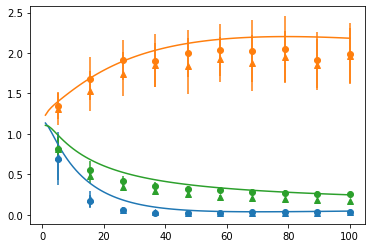

In [ ]:
plt.errorbar(Pvals_expt, err_ker_ben_mod[e_idx][P_idx], std_ker_ben_mod[e_idx][P_idx] , fmt='o', color = 'C%d'%0, label='epoch: %d'%epoch_list[e_idx])
plt.plot(Pvals_th, theory_ben_mod[0][0])

plt.errorbar(Pvals_expt, err_ker_ben[e_idx][P_idx], std_ker_ben[e_idx][P_idx] , fmt='^', color = 'C%d'%0, label='epoch: %d'%epoch_list[e_idx])
#plt.plot(Pvals_th, theory_ben[0][0])

plt.errorbar(Pvals_expt, err_ker_adv_mod[e_idx][P_idx], std_ker_adv_mod[e_idx][P_idx] , fmt='o', color = 'C%d'%1, label='epoch: %d'%epoch_list[e_idx])
plt.plot(Pvals_th, theory_adv_mod[0][0])

plt.errorbar(Pvals_expt, err_ker_adv[e_idx][P_idx], std_ker_adv[e_idx][P_idx] , fmt='^', color = 'C%d'%1, label='epoch: %d'%epoch_list[e_idx])
# plt.plot(Pvals_th, theory_adv[0][0])

plt.errorbar(Pvals_expt, err_ker_uni_mod, std_ker_uni_mod , fmt='o', color = 'C%d'%2, label='epoch: %d'%epoch_list[e_idx])
plt.plot(Pvals_th, theory_uni_mod)

plt.errorbar(Pvals_expt, err_ker_uni, std_ker_uni , fmt='^', color = 'C%d'%2, label='epoch: %d'%epoch_list[e_idx])
# plt.plot(Pvals_th, theory_uni)